In [ ]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text Processing
import re
import string

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)


In [ ]:
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"

df = pd.read_csv(url, sep="\t", names=["label", "message"])
df.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df['label'].value_counts()


,count
label,
0,4825
1,747


In [ ]:
def clean_text(text):
    text = text.lower()

    # Replace URLs
    text = re.sub(r"http\S+|www\S+", " url ", text)

    # Replace emails
    text = re.sub(r'\S+@\S+', ' email ', text)

    # Replace numbers
    text = re.sub(r'\d+', ' number ', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['cleaned'] = df['message'].apply(clean_text)
df.head()


,label,message,cleaned
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in number a wkly comp to win fa cup...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [ ]:
X = df['cleaned']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=7000,
    ngram_range=(1,2)
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [ ]:
param_grid = {
    'C': [0.1, 1, 10]
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    cv=5,
    scoring='f1'
)

grid_lr.fit(X_train_tfidf, y_train)

best_lr = grid_lr.best_estimator_

print("Best Parameters:", grid_lr.best_params_)


Best Parameters: {'C': 10}


In [ ]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Linear SVM
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)


LinearSVC()

In [ ]:
lr_pred = best_lr.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, lr_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, lr_pred))


Accuracy: 0.9856502242152466

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.97      0.93      0.95       149

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



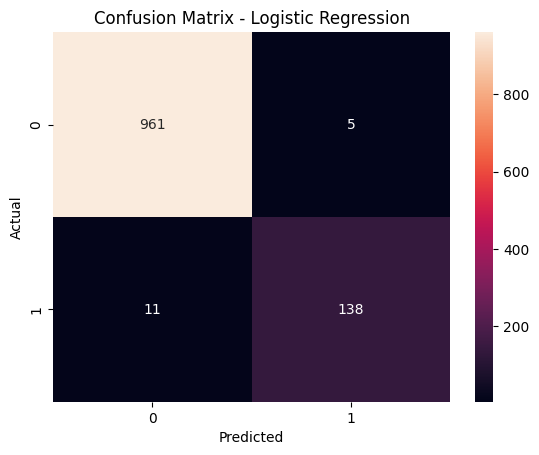

In [ ]:
cm = confusion_matrix(y_test, lr_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


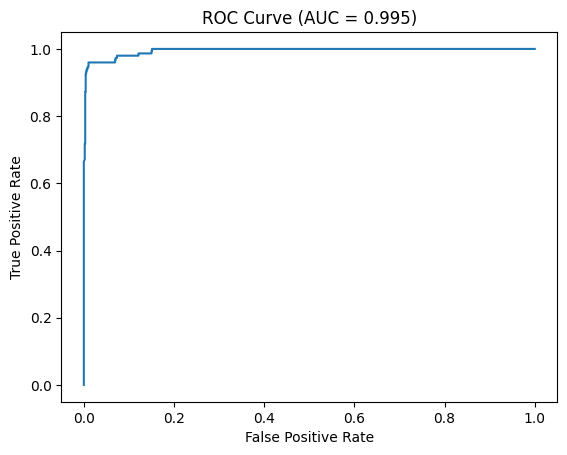

In [ ]:
lr_probs = best_lr.predict_proba(X_test_tfidf)[:,1]

fpr, tpr, _ = roc_curve(y_test, lr_probs)
roc_auc = roc_auc_score(y_test, lr_probs)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.show()


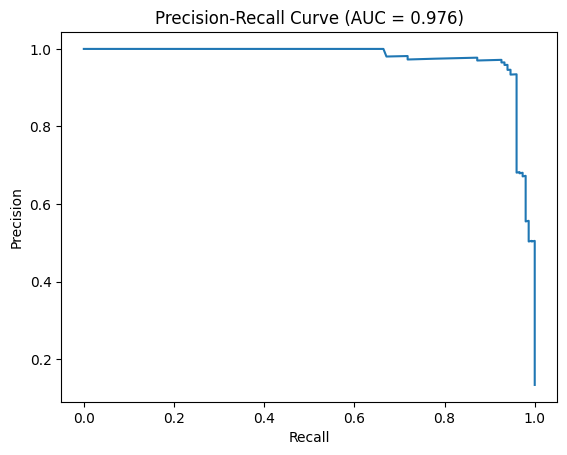

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, lr_probs)
pr_auc = auc(recall, precision)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AUC = {pr_auc:.3f})")
plt.show()


In [ ]:
feature_names = vectorizer.get_feature_names_out()
coefficients = best_lr.coef_[0]

top_spam = np.argsort(coefficients)[-20:]
top_ham = np.argsort(coefficients)[:20]

print("Top Threat Indicators:\n")
for i in reversed(top_spam):
    print(feature_names[i])

print("\nTop Legitimate Indicators:\n")
for i in top_ham:
    print(feature_names[i])


Top Threat Indicators:

url
number
txt
mobile
reply
text
stop
claim
service
number number
choose
games
ringtone
new
win
welcome
won
message
stop number
prize

Top Legitimate Indicators:

ltgt
hey
thats
ill
got
ok
im
home
good
sorry
yep
fine
come
da
work
lor
later
cool
told
way


In [ ]:
def predict_email(email_text):
    cleaned = clean_text(email_text)
    vectorized = vectorizer.transform([cleaned])
    prediction = best_lr.predict(vectorized)
    probability = best_lr.predict_proba(vectorized)[0][1]

    if prediction[0] == 1:
        return f"⚠️ Threat Detected (Confidence: {probability:.2f})"
    else:
        return f"✅ Legitimate Email (Confidence: {1-probability:.2f})"

# Test
predict_email("Urgent! Verify your bank account immediately by clicking this link.")


'✅ Legitimate Email (Confidence: 0.73)'